In [10]:
import codecs
import json
%matplotlib notebook
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import requests
import yaml

<IPython.core.display.Javascript object>


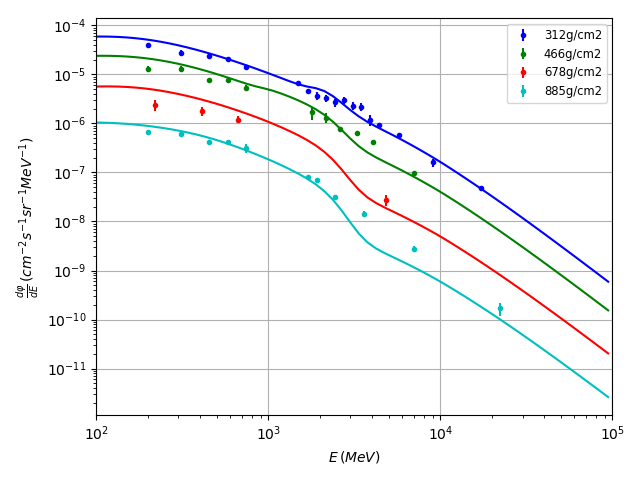

In [11]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k',  'navy', 'orange']
fig = plt.figure()
ax = fig.add_subplot(111)
energy_label = r'$E \, (MeV)$'
ax.set_xlabel(energy_label)
diff_intensity_label = r"$\frac{d \varphi}{d E} \, (cm^{-2} s^{-1} sr^{-1} MeV^{-1})$"
ax.set_ylabel(diff_intensity_label);

Figure 1: The differential intensity of vertical protons at atmospheric depths shown in the legend, as calculated by the Cosmic Ray API and as measured by the CAPRICE apparatus [1]

[1] Mocchiutti, E. (2003). Atmospheric and interstellar cosmic rays measured with the caprice98 experiment (Doctoral dissertation, Fysik).

In [12]:
# construct the target URL
hostname = "https://cosmicrays.amentum.space/api/get_differential_intensity"

In [13]:
# requests lets you pass query string params as a dictionary
payload = {
    'year' : '1998',
    'month' : '5',
    'day' : '28',
    'latitude' : '34.4',
    'longitude' : '-107.6',
    'particle' : 'proton',
    'angle' : '1.0'
}

In [14]:
# include the API key in the request header 
headers = {
  'Authorization' : 'APIKEY'
}

In [15]:
# read the experimental data from YAML file
with open('./protons_mocchiuti.yaml') as f : 
    doc = yaml.load(f, Loader=yaml.FullLoader)
f.close()

In [16]:
for i,plot in enumerate(doc['plots'][::-1]):

    data = np.array(plot['data'])
    kes = data.T[2] # GeV
    intensities = data.T[4] # /m2/s/sr/GeV
    errors = data.T[5] # /m2/s/sr/GeV
    multipliers = data.T[6] #

    # scale the values by the multiplers to separate the plots in y
    intensities *= multipliers
    errors *= multipliers

    atm_depth = plot['atm_depth']['value']
    this_label = np.str(atm_depth) + plot['atm_depth']['units']
    
    print("atmospheric depth ", this_label)
    
    this_color = colors[i]

    ax.errorbar(kes*1000.0 #GeV-> MeV
        , intensities*1e-7  #/m2/s/sr/GeV -> /cm2/s/sr/MeV
        , yerr = errors*1e-7
        , linestyle = "None"
        , marker = "."
        , label = this_label
        , color = this_color)

    # over-write the atmospheric depth parameter for this dataset
    payload['atmospheric_depth'] = str(atm_depth)

    # hit the Cosmic Ray API and fetch the effective dose rate
    try:
        response = requests.get(hostname, params=payload, headers=headers)
    except requests.exceptions.RequestException as e:  
        print(e)
        sys.exit(1)
    
    json_payload = response.json()

    #con
    kes = json_payload["energies"]["data"] # MeV
    flux = json_payload["intensities"]["data"] # /cm2/s/sr/MeV

    ax.plot(kes # MeV
        , flux  #
        , linestyle = "-"
        , marker = "None"
        , color = this_color)

atmospheric depth  312g/cm2
atmospheric depth  466g/cm2
atmospheric depth  678g/cm2
atmospheric depth  885g/cm2


In [17]:
ax.loglog()
ax.grid()
ax.set_xlim(left = 1e2, right =1e5)
ax.legend(loc="upper right", fontsize = 'small', numpoints = 1)
plt.tight_layout()
plt.savefig("protons_mocchiuti.png")
